# IBM Applied Data Science Capstone Course by Coursera
### Week 5 Final Report
**_Opening a New Shared Working Space rental business in Izmir, Turkey._**
- Build a dataframe of neighborhoods in Izmir, Turkey by web scraping the data from https://www.atlasbig.com/tr/izmirin-ilceleri
- Get the geographical coordinates of the neighborhoods
- Obtain the venue data for the neighborhoods from Foursquare API
- Explore and cluster the neighborhoods
- Select the best cluster to open a new Shared Working Space rental business
***

### 1. Import libraries

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import folium
from pandas import json_normalize# tranform JSON file into a pandas dataframe
import numpy as np
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### 2. Scrap the Data

In [3]:
url = "https://www.atlasbig.com/tr/izmirin-ilceleri"
req = requests.get(url)
soup = BeautifulSoup(req.content, 'lxml')

In [4]:
My_table = soup.find_all('td')
My_table

[<td>
 <a href="/tr/izmir-buca">Buca</a>
 </td>,
 <td>			
 																	492,252
 															</td>,
 <td>			
 													
 																			173 
 																								</td>,
 <td>
 <a href="/tr/izmir-karabaglar">Karabağlar</a>
 </td>,
 <td>			
 																	480,790
 															</td>,
 <td>			
 													
 																			92 
 																								</td>,
 <td>
 <a href="/tr/izmir-bornova">Bornova</a>
 </td>,
 <td>			
 																	442,839
 															</td>,
 <td>			
 													
 																			220 
 																								</td>,
 <td>
 <a href="/tr/izmir-konak">Konak</a>
 </td>,
 <td>			
 																	363,181
 															</td>,
 <td>			
 													
 																			25 
 																								</td>,
 <td>
 <a href="/tr/izmir-karsiyaka">Karşıyaka</a>
 </td>,
 <td>			
 																	342,062
 															</td>,
 <td>			
 													
 																			57 
 																								</td>,
 <td>
 <a href="/tr/izmir-bayrakl

Store the scraped data into a pandas dataframe.

In [5]:
res=[]
for tr in My_table:
    td = tr.find_all('a')
    row = [td.text.strip() for td in td if td.text.strip()]
    
    if row:
        res.append(row)
df_izmir=pd.DataFrame(res,columns=["District"])
df_izmir

,District
0,Buca
1,Karabağlar
2,Bornova
3,Konak
4,Karşıyaka
5,Bayraklı
6,Çiğli
7,Torbalı
8,Menemen
9,Gaziemir


### 3. Get the Geographical Coordinates of the Neighborhoods.

In [6]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [7]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Foça, İzmir")
location.longitude

26.858567291777312

In [10]:
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(locator.geocode, min_delay_seconds=5)
df_izmir['location'] = df_izmir['District'].apply(geocode)
df_izmir['point'] = df_izmir['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# split point column into latitude, longitude and altitude columns
df_izmir[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_izmir['point'].tolist(), index=df_izmir.index)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Karşıyaka',), **{}).
Traceback (most recent call last):
  File "/usr/lib/python3.6/urllib/request.py", line 1325, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/usr/lib/python3.6/http/client.py", line 1264, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1310, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1259, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/usr/lib/python3.6/http/client.py", line 1038, in _send_output
    self.send(msg)
  File "/usr/lib/python3.6/http/client.py", line 976, in send
    self.connect()
  File "/usr/lib/python3.6/http/client.py", line 1417, in connect
    super().connect()
  File "/usr/lib/python3.6/http/client.py", line 948, in connect
    (self.host,self.port), sel

In [11]:
df_izmir

,District,location,point,latitude,longitude,altitude
0,Buca,"(Buca, İzmir, Ege Bölgesi, Türkiye, (38.344460...","(38.34446095, 27.262771990750778, 0.0)",38.344461,27.262772,0.0
1,Karabağlar,"(Karabağlar, İzmir, Ege Bölgesi, Türkiye, (38....","(38.3697709, 27.1045922, 0.0)",38.369771,27.104592,0.0
2,Bornova,"(Bornova, İzmir, Ege Bölgesi, Türkiye, (38.467...","(38.4678978, 27.260804924467173, 0.0)",38.467898,27.260805,0.0
3,Konak,"(Konak, İzmir, Ege Bölgesi, Türkiye, (38.41095...","(38.410958, 27.1294534, 0.0)",38.410958,27.129453,0.0
4,Karşıyaka,"(Karşıyaka, İzmir, Ege Bölgesi, Türkiye, (38.5...","(38.5034711, 27.113482575513878, 0.0)",38.503471,27.113483,0.0
5,Bayraklı,"(Bayraklı, İzmir, Ege Bölgesi, Türkiye, (38.48...","(38.4867391, 27.149264834063008, 0.0)",38.486739,27.149265,0.0
6,Çiğli,"(Çiğli, İzmir, Ege Bölgesi, Türkiye, (38.49207...","(38.4920767, 26.994095273338466, 0.0)",38.492077,26.994095,0.0
7,Torbalı,"(Torbalı, İzmir, Ege Bölgesi, 35860, Türkiye, ...","(38.18500375, 27.33664865694812, 0.0)",38.185004,27.336649,0.0
8,Menemen,"(Menemen, İzmir, Ege Bölgesi, 35660, Türkiye, ...","(38.62565515, 27.068946480343836, 0.0)",38.625655,27.068946,0.0
9,Gaziemir,"(Gaziemir, İzmir, Ege Bölgesi, 35410, Türkiye,...","(38.32198175, 27.13270337467273, 0.0)",38.321982,27.132703,0.0


### 4. Display the Neighborhoods on a Map

In [12]:
address = 'İzmir'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of İzmir, Turkiye are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of İzmir, Turkiye are 38.4147331, 27.1434119.


In [13]:
# create map of Toronto using latitude and longitude values
map_izmir = folium.Map(location=[latitude, longitude], zoom_start=8)

# add markers to map
for lat, lng, neighborhood in zip(df_izmir['latitude'], df_izmir['longitude'], df_izmir['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_izmir)  
    
map_izmir

### 5. Use the Foursquare API to explore the neighborhoods

Set up our credentials to make requests to Foursquare API

In [14]:
CLIENT_ID = '31VAXHFA20350LL2SV1BD1INTYMXX3EEM3U2NKVZ5HIRQBBS' # your Foursquare ID
CLIENT_SECRET = '3QKIZATPCAI0QI14MMBXYZW52KXZ5LARAW1O2SCKXBJTIS2B' # your Foursquare Secret
VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 31VAXHFA20350LL2SV1BD1INTYMXX3EEM3U2NKVZ5HIRQBBS
CLIENT_SECRET:3QKIZATPCAI0QI14MMBXYZW52KXZ5LARAW1O2SCKXBJTIS2B


Let's fetch the latitude and longitude of the first neighborhood and get the venues inside it as a test.

In [15]:
neighborhood_latitude = df_izmir.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_izmir.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df_izmir.loc[0, 'District'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Buca are 38.34446095, 27.262771990750778.


In [16]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 4500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=31VAXHFA20350LL2SV1BD1INTYMXX3EEM3U2NKVZ5HIRQBBS&client_secret=3QKIZATPCAI0QI14MMBXYZW52KXZ5LARAW1O2SCKXBJTIS2B&v=20180604&ll=38.34446095,27.262771990750778&radius=4500&limit=100'

In [17]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5edb30fadd0f85001b9c520e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 126,
  'suggestedBounds': {'ne': {'lat': 38.38496099050004,
    'lng': 27.31431434712752},
   'sw': {'lat': 38.303960909499956, 'lng': 27.211229634374035}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5cc870b65d891b002ce905a3',
       'name': 'Han Bağı Et & Kahvaltı Salonu',
       'location': {'address': '29 Ekim Mah.',
        'lat': 38.35647331659168,
        'lng': 27.26180076599121,
        'labeledLatLngs': [{'label': 'display',
          '

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Han Bağı Et & Kahvaltı Salonu,Breakfast Spot,38.356473,27.261801
1,Doğam Restaurant,Turkish Restaurant,38.341247,27.255900
2,Hanci Go-Kart,Go Kart Track,38.344207,27.254912
3,kaynaklar çiftlik evi,Garden,38.360563,27.270789
4,Manzara Garden Kahvaltı Mangal Salonu,Restaurant,38.353664,27.256767


In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
izmir_venues = getNearbyVenues(names=df_izmir['District'],
                                   latitudes=df_izmir['latitude'],
                                   longitudes=df_izmir['longitude']
                                  )

Buca
Karabağlar
Bornova
Konak
Karşıyaka
Bayraklı
Çiğli
Torbalı
Menemen
Gaziemir
Ödemiş
Kemalpaşa
Bergama
Aliağa
menderes
Tire
Balçova
Narlıdere
Urla
Kiraz
Dikili
Çesme
Seferihisar
Bayındır
Selçuk
Güzelbahçe
Foça
Kınık
Beydağ
Karaburun


In [23]:
izmir_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Buca,38.344461,27.262772,Kalabar çiftliği kaynaklar,38.344302,27.266059,Farm
1,Buca,38.344461,27.262772,Bağ Evi,38.346975,27.264549,Garden
2,Buca,38.344461,27.262772,kaynaklar bahçe,38.342677,27.259660,Garden
3,Buca,38.344461,27.262772,Bizim Çiftlik,38.340973,27.260451,Farm
4,Buca,38.344461,27.262772,Doğam Kır Düğün Salonu,38.343646,27.268194,Concert Hall


In [24]:
izmir_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Balçova,25,25,25,25,25,25
Bayraklı,5,5,5,5,5,5
Bayındır,41,41,41,41,41,41
Bergama,100,100,100,100,100,100
Beydağ,2,2,2,2,2,2
Bornova,2,2,2,2,2,2
Buca,5,5,5,5,5,5
Dikili,5,5,5,5,5,5
Foça,5,5,5,5,5,5


In [67]:
# one hot encoding
izmir_onehot = pd.get_dummies(izmir_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
izmir_onehot['Neighborhood'] = izmir_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [izmir_onehot.columns[izmir_onehot.columns.get_loc('Neighborhood')]] + list(izmir_onehot.columns[:-1])
izmir_onehot = izmir_onehot[fixed_columns]
izmir_onehot = izmir_onehot.loc[:,~izmir_onehot.columns.duplicated()]
izmir_onehot.head()

,Neighborhood,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Entertainment,Athletics & Sports,BBQ Joint,Bakery,Bar,...,Toll Booth,Tourist Information Center,Trail,Train Station,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Video Game Store,Waterfront,Wings Joint
0,Buca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Buca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Buca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Buca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Buca,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
izmir_grouped = izmir_onehot.groupby('Neighborhood').mean().reset_index()
print(len(izmir_grouped[izmir_grouped["Restaurant"] > 0]) )
print(len(izmir_grouped[izmir_grouped["Café"] > 0]))
iz_mall=izmir_grouped[["Neighborhood","Café","Restaurant"]]
iz_mall

7
13


,Neighborhood,Café,Restaurant
0,Balçova,0.120000,0.000000
1,Bayraklı,0.000000,0.000000
2,Bayındır,0.073171,0.073171
3,Bergama,0.150000,0.040000
4,Beydağ,0.000000,0.000000
5,Bornova,0.000000,0.000000
6,Buca,0.000000,0.000000
7,Dikili,0.000000,0.000000
8,Foça,0.000000,0.000000
9,Gaziemir,0.141026,0.012821


In [27]:
num_top_venues = 5

for hood in izmir_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = izmir_grouped[izmir_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Balçova----
               venue  freq
0               Café  0.12
1  Convenience Store  0.12
2               Park  0.12
3      Shopping Mall  0.04
4        Music Venue  0.04


----Bayraklı----
                  venue  freq
0        Cosmetics Shop   0.2
1             Pool Hall   0.2
2           Gaming Cafe   0.2
3            Bike Trail   0.2
4  Fast Food Restaurant   0.2


----Bayındır----
                venue  freq
0               Hotel  0.07
1         Pizza Place  0.07
2  Turkish Restaurant  0.07
3          Restaurant  0.07
4                Café  0.07


----Bergama----
                venue  freq
0                Café  0.15
1  Turkish Restaurant  0.07
2         Beer Garden  0.05
3          Restaurant  0.04
4      Breakfast Spot  0.03


----Beydağ----
                           venue  freq
0                    Coffee Shop   0.5
1                           Farm   0.5
2                   Antique Shop   0.0
3  Paper / Office Supplies Store   0.0
4                         Museum   0.0

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = izmir_grouped['Neighborhood']

for ind in np.arange(izmir_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(izmir_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Balçova,Convenience Store,Park,Café,Breakfast Spot,Gym / Fitness Center,Grocery Store,General Travel,Market,Fishing Spot,Fish Market
1,Bayraklı,Cosmetics Shop,Pool Hall,Bike Trail,Fast Food Restaurant,Gaming Cafe,Factory,Fishing Spot,Fish Market,Fish & Chips Shop,Farmers Market
2,Bayındır,Restaurant,Turkish Restaurant,Café,Pizza Place,Hotel,Steakhouse,Sandwich Place,Park,Smoke Shop,Diner
3,Bergama,Café,Turkish Restaurant,Beer Garden,Restaurant,Sandwich Place,Jewelry Store,Lounge,Electronics Store,Breakfast Spot,Mobile Phone Shop
4,Beydağ,Coffee Shop,Farm,Wings Joint,Electronics Store,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Factory
5,Bornova,Stadium,Mountain,Wings Joint,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory
6,Buca,Garden,Farm,Concert Hall,Wings Joint,Electronics Store,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
7,Dikili,Farm,Botanical Garden,Turkish Restaurant,Beer Store,Factory,Flower Shop,Flea Market,Fishing Spot,Fish Market,Fish & Chips Shop
8,Foça,Farm,Moving Target,Print Shop,Gym,Wings Joint,Doner Restaurant,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Factory
9,Gaziemir,Café,Turkish Restaurant,Coffee Shop,Bakery,Dessert Shop,Burger Joint,Gym,Hookah Bar,Music Venue,Mobile Phone Shop


In [30]:
izmir_test=neighborhoods_venues_sorted[(neighborhoods_venues_sorted['1st Most Common Venue']=='Café') | (neighborhoods_venues_sorted['1st Most Common Venue']=='Restaurant')]

In [31]:
izmir_test

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bayındır,Restaurant,Turkish Restaurant,Café,Pizza Place,Hotel,Steakhouse,Sandwich Place,Park,Smoke Shop,Diner
3,Bergama,Café,Turkish Restaurant,Beer Garden,Restaurant,Sandwich Place,Jewelry Store,Lounge,Electronics Store,Breakfast Spot,Mobile Phone Shop
9,Gaziemir,Café,Turkish Restaurant,Coffee Shop,Bakery,Dessert Shop,Burger Joint,Gym,Hookah Bar,Music Venue,Mobile Phone Shop
14,Kiraz,Restaurant,Doner Restaurant,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory,Electronics Store
17,Narlıdere,Café,Wings Joint,Flower Shop,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory


In [32]:
izmir_grouped.drop('Neighborhood', 1)

,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Entertainment,Athletics & Sports,BBQ Joint,Bakery,Bar,Basketball Court,...,Toll Booth,Tourist Information Center,Trail,Train Station,Turkish Coffeehouse,Turkish Home Cooking Restaurant,Turkish Restaurant,Video Game Store,Waterfront,Wings Joint
0,0.00,0.00000,0.000000,0.040000,0.00000,0.04,0.000000,0.000000,0.000000,0.040000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00000,0.024390,0.000000,0.00000,0.00,0.024390,0.024390,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.024390,0.000000,0.073171,0.000000,0.000000,0.000000
3,0.01,0.00000,0.000000,0.010000,0.00000,0.00,0.000000,0.010000,0.010000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.010000,0.070000,0.000000,0.000000,0.000000
4,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000
8,0.00,0.00000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00000,0.025641,0.012821,0.00000,0.00,0.000000,0.064103,0.012821,0.000000,...,0.00000,0.0,0.00,0.000000,0.000000,0.012821,0.089744,0.000000,0.000000,0.012821


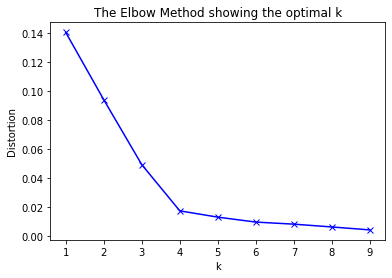

In [33]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
distortions = []
K = range(1,10)
for k in K:
# set number of clusters
   # kclusters = 7

    izmir_grouped_clustering =iz_mall.drop('Neighborhood', 1)

# run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(izmir_grouped_clustering)
    distortions.append(sum(np.min(cdist(izmir_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / izmir_grouped_clustering.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()
# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10] 

In [34]:
# set number of clusters
kclusters = 4

izmir_grouped_clustering = iz_mall.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(izmir_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 3, 3, 0, 0, 0, 0, 0, 3], dtype=int32)

In [35]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

izmir_merged = df_izmir

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
izmir_merged = izmir_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='District')

izmir_merged.head() # check the last columns!
izmir_merged=izmir_merged.dropna()

In [36]:
izmir_merged

,District,location,point,latitude,longitude,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buca,"(Buca, İzmir, Ege Bölgesi, Türkiye, (38.344460...","(38.34446095, 27.262771990750778, 0.0)",38.344461,27.262772,0.0,0.0,Garden,Farm,Concert Hall,Wings Joint,Electronics Store,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
1,Karabağlar,"(Karabağlar, İzmir, Ege Bölgesi, Türkiye, (38....","(38.3697709, 27.1045922, 0.0)",38.369771,27.104592,0.0,3.0,Convenience Store,Plaza,Café,Arcade,Arts & Entertainment,Pharmacy,Kokoreç Restaurant,Shopping Mall,Kebab Restaurant,Deli / Bodega
2,Bornova,"(Bornova, İzmir, Ege Bölgesi, Türkiye, (38.467...","(38.4678978, 27.260804924467173, 0.0)",38.467898,27.260805,0.0,0.0,Stadium,Mountain,Wings Joint,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory
3,Konak,"(Konak, İzmir, Ege Bölgesi, Türkiye, (38.41095...","(38.410958, 27.1294534, 0.0)",38.410958,27.129453,0.0,0.0,Bakery,Borek Place,Kokoreç Restaurant,Flower Shop,Turkish Restaurant,Park,History Museum,Plaza,Soccer Field,Kofte Place
4,Karşıyaka,"(Karşıyaka, İzmir, Ege Bölgesi, Türkiye, (38.5...","(38.5034711, 27.113482575513878, 0.0)",38.503471,27.113483,0.0,0.0,Mountain,Market,Garden,Farm,Wings Joint,Factory,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
5,Bayraklı,"(Bayraklı, İzmir, Ege Bölgesi, Türkiye, (38.48...","(38.4867391, 27.149264834063008, 0.0)",38.486739,27.149265,0.0,0.0,Cosmetics Shop,Pool Hall,Bike Trail,Fast Food Restaurant,Gaming Cafe,Factory,Fishing Spot,Fish Market,Fish & Chips Shop,Farmers Market
6,Çiğli,"(Çiğli, İzmir, Ege Bölgesi, Türkiye, (38.49207...","(38.4920767, 26.994095273338466, 0.0)",38.492077,26.994095,0.0,0.0,Video Game Store,Market,Trail,Gun Range,Wings Joint,Doner Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
7,Torbalı,"(Torbalı, İzmir, Ege Bölgesi, 35860, Türkiye, ...","(38.18500375, 27.33664865694812, 0.0)",38.185004,27.336649,0.0,0.0,Rest Area,Wings Joint,Doner Restaurant,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory
8,Menemen,"(Menemen, İzmir, Ege Bölgesi, 35660, Türkiye, ...","(38.62565515, 27.068946480343836, 0.0)",38.625655,27.068946,0.0,0.0,Gift Shop,Farm,Wings Joint,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Factory,Electronics Store
9,Gaziemir,"(Gaziemir, İzmir, Ege Bölgesi, 35410, Türkiye,...","(38.32198175, 27.13270337467273, 0.0)",38.321982,27.132703,0.0,3.0,Café,Turkish Restaurant,Coffee Shop,Bakery,Dessert Shop,Burger Joint,Gym,Hookah Bar,Music Venue,Mobile Phone Shop


In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(izmir_merged['latitude'], izmir_merged['longitude'], izmir_merged['District'], izmir_merged['Cluster Labels']):
    
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now that we have clustered our neighborhoods in Izmir, Let's check how our clusters look like.

In [119]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 0, izmir_merged.columns[[1] + list(range(5, izmir_merged.shape[1]))]].head()

,location,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"(Buca, İzmir, Ege Bölgesi, Türkiye, (38.34446095, 27.262771990750778))",0.0,0.0,Garden,Farm,Concert Hall,Wings Joint,Electronics Store,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
2,"(Bornova, İzmir, Ege Bölgesi, Türkiye, (38.4678978, 27.260804924467173))",0.0,0.0,Stadium,Mountain,Wings Joint,Electronics Store,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory
3,"(Konak, İzmir, Ege Bölgesi, Türkiye, (38.410958, 27.1294534))",0.0,0.0,Bakery,Borek Place,Kokoreç Restaurant,Flower Shop,Turkish Restaurant,Park,History Museum,Plaza,Soccer Field,Kofte Place
4,"(Karşıyaka, İzmir, Ege Bölgesi, Türkiye, (38.5034711, 27.113482575513878))",0.0,0.0,Mountain,Market,Garden,Farm,Wings Joint,Factory,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market
5,"(Bayraklı, İzmir, Ege Bölgesi, Türkiye, (38.4867391, 27.149264834063008))",0.0,0.0,Cosmetics Shop,Pool Hall,Bike Trail,Fast Food Restaurant,Gaming Cafe,Factory,Fishing Spot,Fish Market,Fish & Chips Shop,Farmers Market


In [120]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 1, izmir_merged.columns[[1] + list(range(5, izmir_merged.shape[1]))]].head()

,location,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,"(Kiraz, İzmir, Ege Bölgesi, 35890, Türkiye, (38.2284347, 28.314383142068678))",0.0,1.0,Restaurant,Doner Restaurant,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory,Electronics Store


In [121]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 2, izmir_merged.columns[[1] + list(range(5, izmir_merged.shape[1]))]].head()

,location,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,"(Narlıdere, İzmir, Ege Bölgesi, 35320, Türkiye, (38.37256945, 26.975152098414156))",0.0,2.0,Café,Wings Joint,Flower Shop,Fishing Spot,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Factory


In [122]:
izmir_merged.loc[izmir_merged['Cluster Labels'] == 3, izmir_merged.columns[[1] + list(range(5, izmir_merged.shape[1]))]].head()

,location,altitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"(Karabağlar, İzmir, Ege Bölgesi, Türkiye, (38.3697709, 27.1045922))",0.0,3.0,Convenience Store,Plaza,Café,Arcade,Arts & Entertainment,Pharmacy,Kokoreç Restaurant,Shopping Mall,Kebab Restaurant,Deli / Bodega
9,"(Gaziemir, İzmir, Ege Bölgesi, 35410, Türkiye, (38.32198175, 27.13270337467273))",0.0,3.0,Café,Turkish Restaurant,Coffee Shop,Bakery,Dessert Shop,Burger Joint,Gym,Hookah Bar,Music Venue,Mobile Phone Shop
10,"(Ödemiş, İzmir, Ege Bölgesi, 35750, Türkiye, (38.2313406, 27.9751807))",0.0,3.0,Turkish Restaurant,Café,Sandwich Place,Electronics Store,Restaurant,Clothing Store,Men's Store,Steakhouse,Candy Store,Coffee Shop
12,"(Bergama, İzmir, Ege Bölgesi, 35700, Türkiye, (39.1191544, 27.1777296))",0.0,3.0,Café,Turkish Restaurant,Beer Garden,Restaurant,Sandwich Place,Jewelry Store,Lounge,Electronics Store,Breakfast Spot,Mobile Phone Shop
15,"(Tire, İzmir, Ege Bölgesi, 35900, Türkiye, (38.0878154, 27.721173034972082))",0.0,3.0,Tea Room,Business Service,Café,Coffee Shop,Electronics Store,Basketball Court,Nightclub,Other Event,Shop & Service,Big Box Store


To aid our decision, let's construct a heat map.

#### Let's Visualize the density of Cafe's in the different neighborhoods located in Izmir.

In [118]:
# create map of Toronto using latitude and longitude values
map_izmir1 = folium.Map(location=[latitude, longitude], zoom_start=8)

for lat, lon, poi, cluster in zip(izmir_merged['latitude'], izmir_merged['longitude'], izmir_merged['District'], izmir_merged['Cluster Labels']):
    
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_izmir1)
    
from folium.plugins import HeatMap
df_copy = izmir_venues[izmir_venues['Venue Category']=='Café'].copy()
df_copy['count'] = 1
HeatMap(data=df_copy[['Neighborhood Latitude', 'Neighborhood Longitude', 'count']].groupby(['Neighborhood Latitude', 'Neighborhood Longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=2).add_to(map_izmir1)
map_izmir1

According to the requirements put by the clients, It is prefered for the new business to be located in an area where Cafes and other facilities are populated as well as central part of the city. Based on that, the clustering of the neighborhoods resulted in 2 potential clusters. (Cluster 0 and 3). In order to provide more insights for decision making, heat maps were contructed. According to the results on the heatmap, Cluster 0 contains neighborhoods that are in the central area of the city or atleast closer. In an attempt to choose one neghborhood for the workspace business, Konak will be a potential location as it is both located in the central area of the city and it has wide range of supporting facilities such as cafes. One additional advantage of choosing Konak would be the fact that it is located closer to the Sea helps customers get fresh air as well as amazing views.